# StableStacks usign InceptionV4
Experiment based on: https://arxiv.org/pdf/1804.08018

## Import the Necessary Libraries

In [1]:
# Import necessary libraries for deep learning, data processing, and evaluation
import timm
import torch
import os
import numpy as np
import pandas as pd
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

## Load the Pre-trained Model

In [2]:
# Initialize the Inception v4 model and load pre-trained weights
model = timm.create_model('inception_v4', pretrained=False)
model.load_state_dict(torch.load("inception_v4_weights.pth"))
model

InceptionV4(
  (features): Sequential(
    (0): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (2): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (3): Mixed3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (c

## Network Layer Structure

In [3]:
import torch.nn as nn
from torchvision import models
class inceptionv4_mlp(nn.Module):
    def __init__(self):
        super(inceptionv4_mlp, self).__init__()
        
        self.inception_v4 = timm.create_model('inception_v4', pretrained=False)
        self.inception_v4.load_state_dict(torch.load("inception_v4_weights.pth"))

        self.inception_v4.last_linear = nn.Linear(1536, 6)
        self.fc = nn.Sequential(
            nn.Linear(1000, 256), 
            # nn.Sigmoid(),
            # nn.Dropout(0.2),
            # nn.Linear(256, 64),  
            # nn.Sigmoid(),
            # nn.Dropout(0.2),
            # nn.Linear(64, 32),  
            # nn.Sigmoid(),
            # nn.Dropout(0.1),
            # nn.Linear(32, 6),  
        )

    def forward(self, x):        
        x = self.inception_v4(x)  
        return x

# Model Training

## Classify the Stable Heights

In [4]:
# Custom Dataset for loading images and labels with optional transformations
class InputDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, str(self.df.iloc[idx, 0])) + ".jpg")
        label = self.df.iloc[idx, -1]  
        instability_type = self.df.iloc[idx, 4]  

        if self.transform:
            image = self.transform(image)

        return image, label, instability_type 

# Trainer class for handling model training and validation
class TaskTrainer:
    def __init__(self, csv_file, img_dir, model, stratify_column='stable_height', test_size=0.2, batch_size=128,
                 num_epochs=30, learning_rate=0.001, random_state=0):
        # Initialize key parameters and load the model
        self.csv_file = csv_file
        self.img_dir = img_dir
        self.stratify_column = stratify_column
        self.test_size = test_size
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.model = model

        # Set device (GPU if available, otherwise CPU)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Load dataset and split it into training and validation sets
        self.data_frame = pd.read_csv(csv_file)
        self.train_data, self.val_data = train_test_split(
            self.data_frame, test_size=self.test_size, random_state=self.random_state
        )
        print(f"size_of_train: {len(self.train_data)}, size_of_val: {len(self.val_data)}")

        # Define data transformations for training and validation
        self.transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=0, translate=(0.08, 0.08), scale=(1.0, 1.2)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.transforms_val = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create DataLoaders for training and validation
        self.train_loader = self.create_dataloader(self.train_data, self.transforms)
        self.val_loader = self.create_dataloader(self.val_data, self.transforms_val, shuffle=False)

        # Define loss functions and optimizer
        self.compute_mse = nn.MSELoss()
        weights = torch.tensor(
            list(self.data_frame['stable_height'].value_counts() / len(self.data_frame)),
            device=self.device
        )
        self.compute_loss = torch.nn.CrossEntropyLoss(weight=weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-6)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=12, gamma=0.1)


    # Create DataLoader from the given DataFrame and transformations
    def create_dataloader(self, data_frame, transform, shuffle=True):
        dataset = InputDataset(data_frame, self.img_dir, transform=transform)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    # Calculate AUC for each class and return the highest AUC value
    def calculate_auc(self, outputs, labels):
        predict = torch.round(outputs).clamp(0, 5).cpu().numpy()
        labels = labels.cpu().numpy()
        class_auc = {}

        for i in range(6):
            y_true_i = (labels == i)
            fpr_i, tpr_i, _ = roc_curve(y_true_i, predict)
            class_auc[i] = auc(fpr_i, tpr_i)

        return np.max(list(class_auc.values()))

    # Generate and print a classification report
    def generate_classification_report(self, outputs, labels):
        predict = torch.round(outputs).clamp(0, 5).cpu().numpy()
        labels = labels.cpu().numpy()
        report = classification_report(labels, predict, zero_division=0)
        print(report)
        return report

    # Calculate and print a confusion matrix
    def calculate_confusion_matrix(self, outputs, labels):
        predict = torch.round(outputs).clamp(0, 5).cpu().numpy()
        labels = labels.cpu().numpy()
        cm = confusion_matrix(labels, predict)
        print(cm)
        return cm

    # Validate the model and compute metrics
    def validate(self):
        self.model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        total_F1 = 0
        MSE = 0

        all_labels = []
        all_predictions = []

        # Open a file to write validation report
        file_valid = open('report.txt', 'a')

        with torch.no_grad():  # Disable gradient computation for validation
            for features, labels, _ in self.val_loader:
                # Move data to the appropriate device
                features, labels = features.to(self.device), labels.to(self.device).long() - 1
                outputs = self.model(features)

                # Get the predicted category
                _, outputs_cate = torch.max(outputs, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(outputs_cate.cpu().numpy())

                # Compute loss and update total loss
                loss = self.compute_loss(outputs.squeeze(), labels)
                val_loss += loss.item()

                # Update correct predictions and sample count
                correct_predictions += (outputs_cate == labels).sum().item()
                total_samples += labels.size(0)

                # Calculate weighted F1 score
                F1 = f1_score(labels.cpu().numpy(), outputs_cate.cpu().numpy(), average='weighted')
                total_F1 += F1

                # Compute MSE
                mse = self.compute_mse(outputs_cate, labels.float()).cpu().numpy()
                MSE += mse

        # Compute overall metrics
        val_accuracy = correct_predictions / total_samples
        total_F1 /= len(self.val_loader)
        MSE /= len(self.val_loader)

        # Generate classification report and confusion matrix
        report = self.generate_classification_report(torch.tensor(all_predictions), torch.tensor(all_labels))
        matrix = self.calculate_confusion_matrix(torch.tensor(all_predictions), torch.tensor(all_labels))

        # Write report and matrix to the report file
        file_valid.write('report:')
        file_valid.write(str(report))
        file_valid.write('matrix:')
        file_valid.write(str(matrix))
        file_valid.close()

        # Calculate average loss
        loss_final = val_loss / len(self.val_loader)

        return loss_final, val_accuracy, total_F1, MSE

    # Train the model and log metrics
    def train(self):
        tfevent_dir = "experiment/tfevent"
        model_dir = "trained_models_save"

        # Create directories if they don't exist
        os.makedirs(tfevent_dir, exist_ok=True)
        os.makedirs(model_dir, exist_ok=True)

        writer = SummaryWriter(tfevent_dir)  # TensorBoard writer for logging
        best_val_accuracy = 0.0  # Track the best validation accuracy

        for epoch in range(self.num_epochs):
            self.model.train()  # Set model to training mode
            running_loss = 0.0
            running_accuracy = 0.0
            total_F1 = 0.0

            print(f"Epoch {epoch + 1}/{self.num_epochs}")

            for batch, (features, labels, _) in enumerate(self.train_loader):
                features, labels = features.to(self.device), labels.to(self.device).long() - 1

                self.optimizer.zero_grad()
                outputs = self.model(features).to(self.device)
                _, predictions = torch.max(outputs, dim=1)

                loss = self.compute_loss(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # Update metrics
                running_loss += loss.item()
                correct = (predictions == labels).sum().item()
                accuracy = correct / labels.size(0)
                running_accuracy += accuracy

                F1 = f1_score(labels.cpu(), predictions.cpu(), average='weighted')
                total_F1 += F1

                MSE = self.compute_mse(predictions, labels.float()).cpu().numpy()

                # Log batch metrics to TensorBoard
                writer.add_scalar('Training Loss', loss.item(), batch + epoch * len(self.train_loader))
                writer.add_scalar('Training Acc', accuracy, batch + epoch * len(self.train_loader))
                writer.add_scalar('Training MSE', MSE, batch + epoch * len(self.train_loader))
                writer.add_scalar('Training F1', F1, batch + epoch * len(self.train_loader))

            # Log epoch-level metrics to TensorBoard
            writer.add_scalar('Epoch Loss', running_loss / len(self.train_loader), epoch)
            writer.add_scalar('Epoch Acc', running_accuracy / len(self.train_loader), epoch)
            writer.add_scalar('Epoch F1', total_F1 / len(self.train_loader), epoch)

            # Log parameter histograms
            for name, param in self.model.named_parameters():
                writer.add_histogram(name, param, epoch)

            writer.flush()

            # Validate the model and log validation metrics
            val_loss, val_accuracy, val_F1, val_MSE = self.validate()
            writer.add_scalar('val_loss', val_loss, epoch)
            writer.add_scalar('val_acc', val_accuracy, epoch)
            writer.add_scalar('val_F1', val_F1, epoch)
            writer.add_scalar('val_MSE', val_MSE, epoch)

            print(
                f"Epoch [{epoch + 1}/{self.num_epochs}], "
                f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
                f"Val F1: {val_F1:.4f}, Val MSE: {val_MSE:.4f}"
            )

            # Save the best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(self.model.state_dict(), f"{model_dir}/best_model.pth")
                print(f"Best validation accuracy: {best_val_accuracy:.4f}")


In [5]:
# Initialize the trainer and start training
trainer = TaskTrainer(
    csv_file='COMP90086_2024_Project_train/train.csv',
    img_dir='COMP90086_2024_Project_train/train',
    model=inceptionv4_mlp(),
    batch_size=128,
    num_epochs=30,
    learning_rate=0.001
)

trainer.train()


size_of_train: 6144, size_of_val: 1536
Epoch 1/30
              precision    recall  f1-score   support

           0       0.34      0.79      0.48       395
           1       0.17      0.13      0.15       357
           2       0.27      0.25      0.26       311
           3       0.30      0.05      0.09       245
           4       0.00      0.00      0.00       151
           5       0.00      0.00      0.00        77

    accuracy                           0.29      1536
   macro avg       0.18      0.20      0.16      1536
weighted avg       0.23      0.29      0.22      1536

[[314  38  39   4   0   0]
 [268  46  41   2   0   0]
 [146  76  78  11   0   0]
 [ 95  61  76  13   0   0]
 [ 67  38  35  11   0   0]
 [ 37  18  19   3   0   0]]
Epoch [1/30], Val Loss: 3.0051, Val Accuracy: 0.2936, Val F1: 0.2230, Val MSE: 3.4857
Best validation accuracy: 0.2936
Epoch 2/30
              precision    recall  f1-score   support

           0       0.39      0.30      0.34       395
     

## Load Model to Predict

In [6]:
# Dataset for loading test images
class TestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, str(self.df.iloc[idx, 0])) + ".jpg")
        if self.transform:
            image = self.transform(image)
        return image, self.df.iloc[idx, 0]

# Class for loading a trained model and making predictions on test data
class TestPredictor:
    def __init__(self, model, model_path, test_file, img_dir, batch_size=32):
        self.model = model
        self.model_path = model_path
        self.test_file = test_file
        self.img_dir = img_dir
        self.batch_size = batch_size

        # Set device to GPU if available, else CPU
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        # Load model weights and set to evaluation mode
        self.model.load_state_dict(torch.load(self.model_path, map_location=self.device))
        self.model.eval()

        self.transform = transforms.Compose([transforms.ToTensor()])

        # Load test data and create DataLoader
        self.data_test = pd.read_csv(test_file)
        self.test_loader = self.create_dataloader()

    def create_dataloader(self):
        test_dataset = TestDataset(self.data_test, self.img_dir, transform=self.transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    def predict(self):
        all_predictions = []
        all_image_ids = []

        with torch.no_grad():  # Disable gradients for inference
            for images, image_ids in tqdm(self.test_loader, desc="predict"):
                all_image_ids.extend(image_ids.numpy())
                outputs = self.model(images.to(self.device))
                predictions = torch.argmax(outputs, 1).cpu().numpy()
                all_predictions.extend(predictions.astype(int) + 1)

        return pd.DataFrame({'id': all_image_ids, 'stable_height': all_predictions})

    def save_predictions(self, output_csv):
        prediction_df = self.predict()
        prediction_df.to_csv(output_csv, index=False)
        print(f"Saved: {output_csv}")


In [7]:
# Initialize the model and set paths for the best model and test data
model = inceptionv4_mlp()
model_dir = "trained_models_save"
model_path = f'{model_dir}/best_model.pth'

test_file = 'COMP90086_2024_Project_test/test.csv'
img_dir = 'COMP90086_2024_Project_test/test'

# Initialize the TestPredictor and generate predictions
predictor = TestPredictor(
    model=model,
    model_path=model_path,
    test_file=test_file,
    img_dir=img_dir,
    batch_size=32
)

# Predict and save results to a CSV file
prediction_df = predictor.predict()
predictor.save_predictions('predictions.csv')


predict: 100%|██████████| 60/60 [00:05<00:00, 11.46it/s]

Saved: predictions.csv


## Visualisation

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker

In [24]:
# Read the content of 'report.txt', remove the "matrix:" prefix from each line, and store the cleaned lines in a new list.
file_vision_tmp = open('report.txt', 'r').readlines()
file_vision = []
for l in file_vision_tmp:
    file_vision.append(l.replace("matrix:", ""))

file_vision


['report:              precision    recall  f1-score   support\n',
 '\n',
 '           0       0.34      0.79      0.48       395\n',
 '           1       0.17      0.13      0.15       357\n',
 '           2       0.27      0.25      0.26       311\n',
 '           3       0.30      0.05      0.09       245\n',
 '           4       0.00      0.00      0.00       151\n',
 '           5       0.00      0.00      0.00        77\n',
 '\n',
 '    accuracy                           0.29      1536\n',
 '   macro avg       0.18      0.20      0.16      1536\n',
 'weighted avg       0.23      0.29      0.22      1536\n',
 '[[314  38  39   4   0   0]\n',
 ' [268  46  41   2   0   0]\n',
 ' [146  76  78  11   0   0]\n',
 ' [ 95  61  76  13   0   0]\n',
 ' [ 67  38  35  11   0   0]\n',
 ' [ 37  18  19   3   0   0]]report:              precision    recall  f1-score   support\n',
 '\n',
 '           0       0.39      0.30      0.34       395\n',
 '           1       0.37      0.59      0.46       3

In [25]:
# Extract metrics from the input data and compute averages for grouped elements.
def read_data(target, lines):
    res_precision = []
    res_recall = []
    res_f1 = []
    val_accuracy = []
    for line in lines:
        line_split = line.split()
        if len(line_split) == 0:
            continue
        if line_split[0] == str(target):
            res_precision.append(float(line_split[1]))
            res_recall.append(float(line_split[2]))
            res_f1.append(float(line_split[3]))
        if line_split[0] == 'accuracy':
            val_accuracy.append(float(line_split[1]))
    return res_precision, res_recall, res_f1, val_accuracy

def average_every_five(numbers, x):
    if len(numbers) % x != 0:
        raise ValueError("List length must be divisible by x.")
    return [sum(numbers[i:i + x]) / x for i in range(0, len(numbers), x)]


## Precision

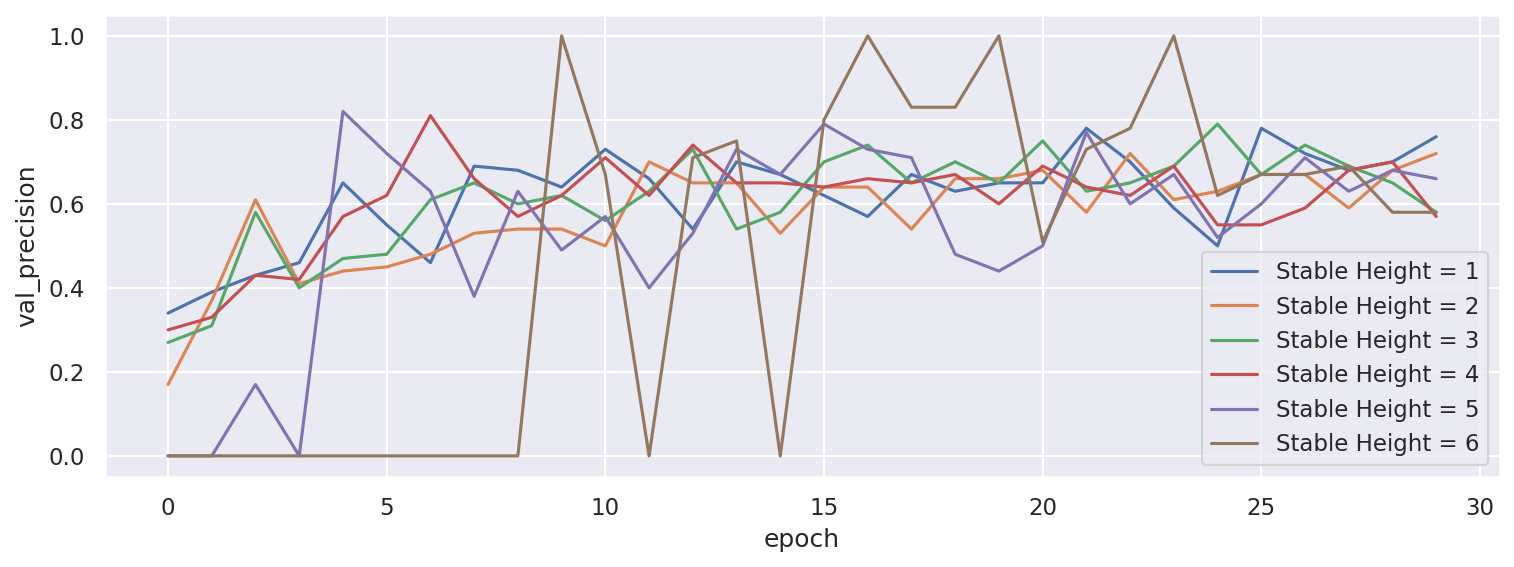

In [27]:
# Visualise Precision
plt.figure(figsize=(12, 4), dpi=150)
sns.set() 

for i in range(6):
    res_precision, res_recall, res_f1, val_accuracy = read_data(target=i, lines=file_vision)
    averages = average_every_five(res_precision, 1)
    plt.plot(averages , alpha=1, label = 'Stable Height = '+str(i+1))

plt.legend()
plt.xlabel('epoch')
plt.ylabel('val_precision')
plt.show()

## Recall

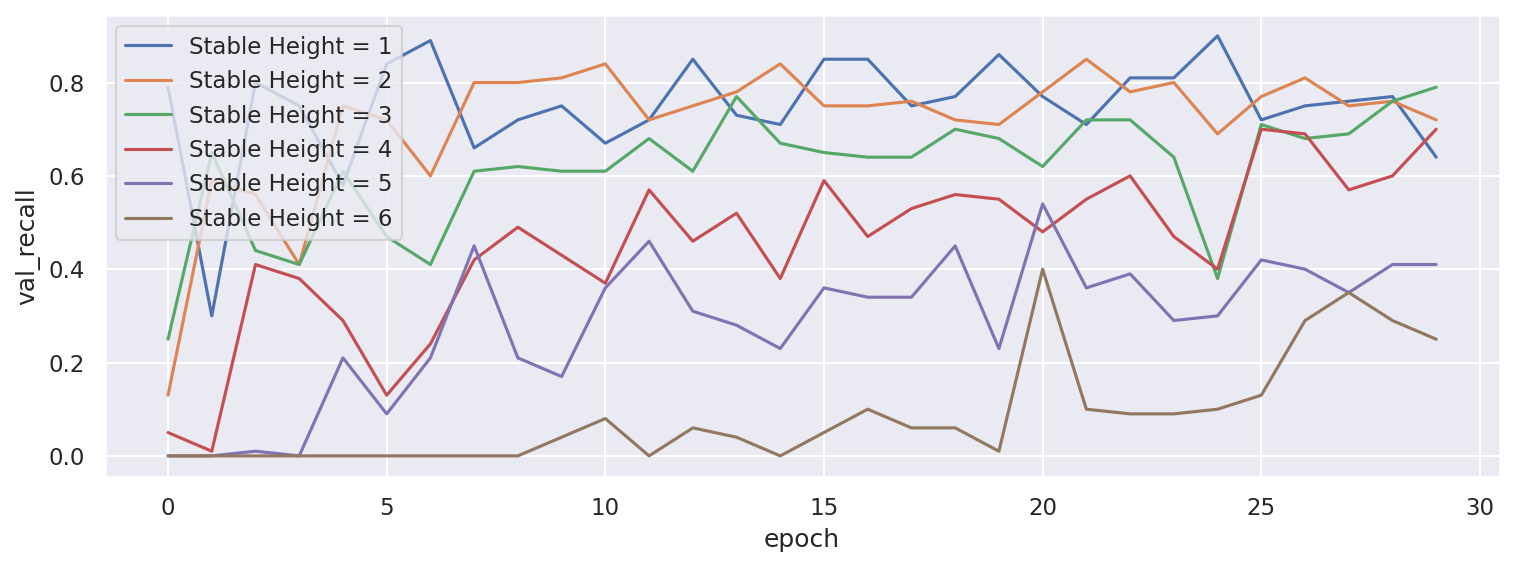

In [28]:
# Visualise Recall
plt.figure(figsize=(12, 4), dpi=150)
sns.set() 

for i in range(6):
    res_precision, res_recall, res_f1, val_accuracy = read_data(target=i, lines=file_vision)
    averages = average_every_five(res_recall, 1)
    plt.plot(averages , alpha=1, label = 'Stable Height = '+str(i+1))

plt.legend()
plt.xlabel('epoch')
plt.ylabel('val_recall')
plt.show()

## F1_Score

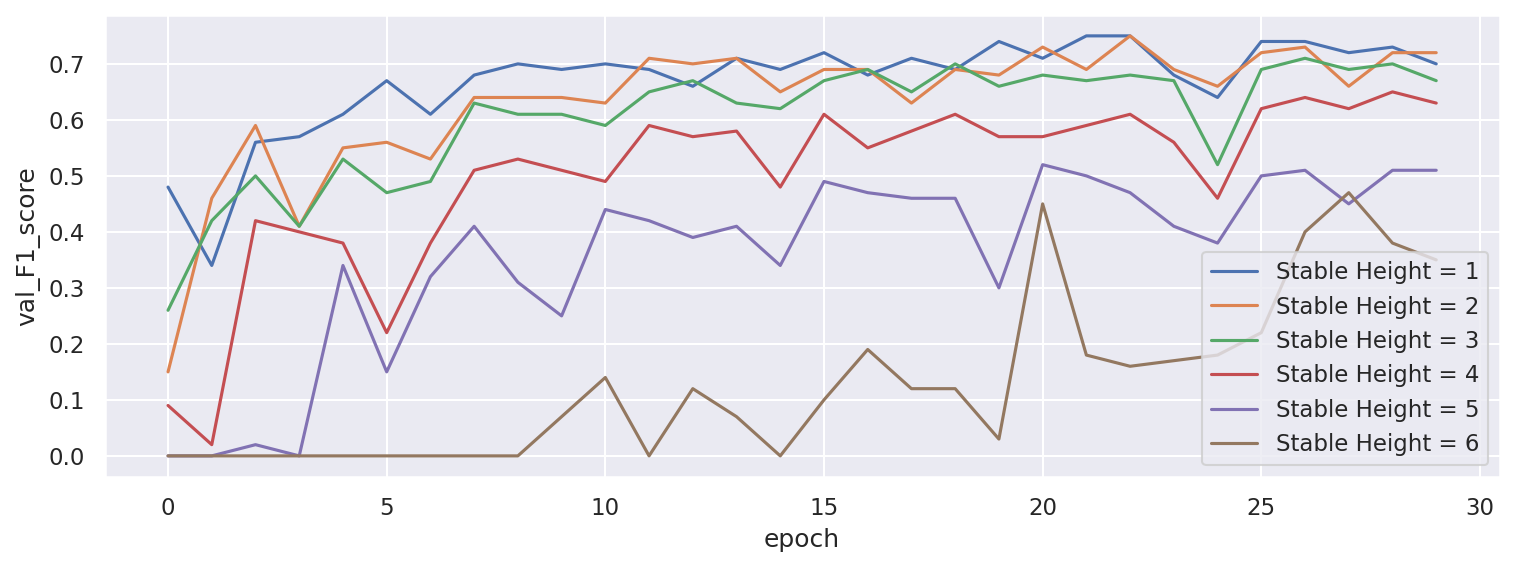

In [29]:
# Visualise F1_Score
plt.figure(figsize=(12, 4), dpi=150)
sns.set() 

for i in range(6):
    res_precision, res_recall, res_f1, val_accuracy = read_data(target=i, lines=file_vision)
    averages = average_every_five(res_f1, 1)
    plt.plot(averages , alpha=1, label = 'Stable Height = '+str(i+1))

plt.legend()
plt.xlabel('epoch')
plt.ylabel('val_F1_score')
plt.show()

## Accuracy

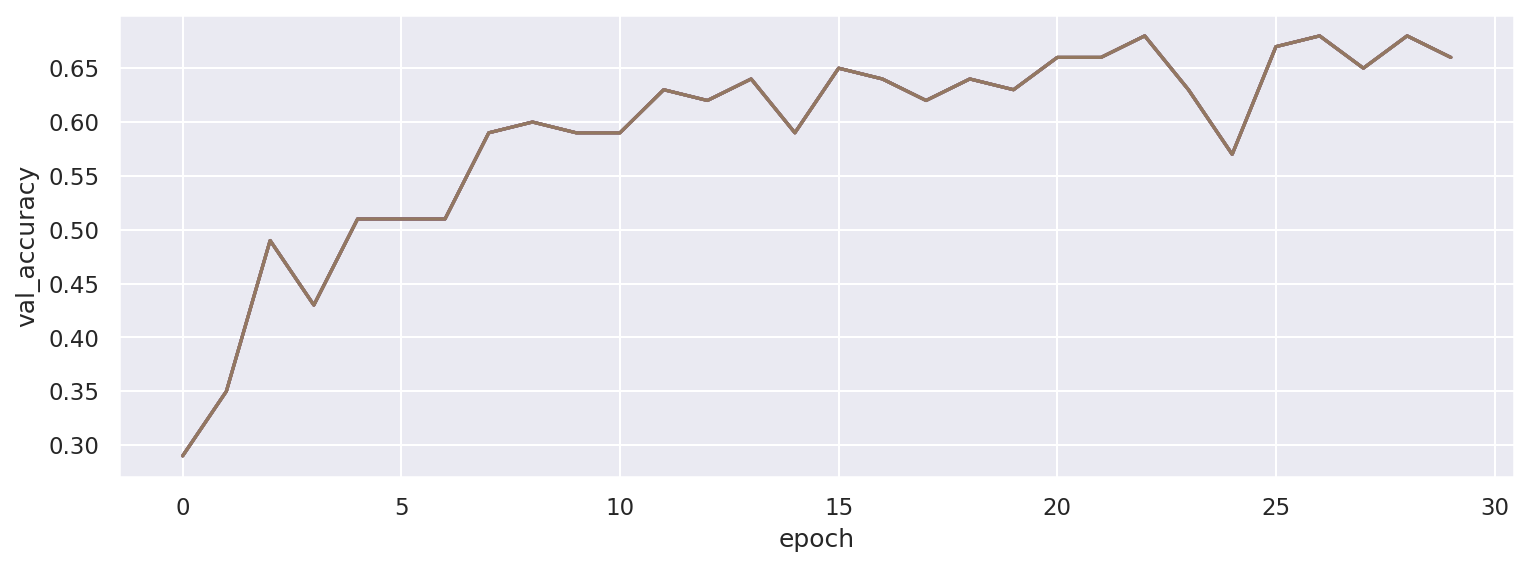

In [30]:
#Visualise Accuracy
plt.figure(figsize=(12, 4), dpi=150)
sns.set() 

for i in range(6):
    res_precision, res_recall, res_f1, val_accuracy = read_data(target=i, lines=file_vision)
    averages = average_every_five(val_accuracy, 1)
    plt.plot(averages , alpha=1, label = 'cate'+str(i))

plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()

## Confusion Matrix

In [31]:
# Extract matrices from the input data and store them in a list.
def read_matrix(file_vision):
    count = 0
    total_matrix = []

    while count < len(file_vision):
        line = file_vision[count].split()
        if not line:
            count += 1
            continue
        if file_vision[count][:2] == '[[':
            matrixs = []
            for _ in range(6):
                matrix = [int(num) for num in file_vision[count][2:25].split()]
                matrixs.append(matrix)
                count += 1
                if count == len(file_vision):
                    break
            total_matrix.append(matrixs)
        else:
            count += 1

    return total_matrix

# Call the function to read matrices.
total_matrix = read_matrix(file_vision)
total_matrix


[[[314, 38, 39, 4, 0, 0],
  [268, 46, 41, 2, 0, 0],
  [146, 76, 78, 11, 0, 0],
  [95, 61, 76, 13, 0, 0],
  [67, 38, 35, 11, 0, 0],
  [37, 18, 19, 3, 0, 0]],
 [[117, 180, 97, 1, 0, 0],
  [26, 211, 120, 0, 0, 0],
  [39, 69, 203, 0, 0, 0],
  [54, 50, 138, 3, 0, 0],
  [43, 36, 67, 5, 0, 0],
  [18, 20, 39, 0, 0, 0]],
 [[315, 39, 24, 16, 1, 0],
  [116, 201, 24, 15, 1, 0],
  [88, 57, 136, 28, 2, 0],
  [87, 13, 41, 101, 3, 0],
  [76, 13, 4, 56, 2, 0],
  [43, 6, 5, 20, 3, 0]],
 [[296, 64, 20, 15, 0, 0],
  [101, 146, 96, 14, 0, 0],
  [100, 43, 127, 41, 0, 0],
  [68, 43, 40, 94, 0, 0],
  [53, 36, 16, 46, 0, 0],
  [21, 25, 17, 12, 2, 0]],
 [[230, 101, 56, 6, 2, 0],
  [44, 268, 37, 8, 0, 0],
  [26, 90, 189, 6, 0, 0],
  [33, 46, 94, 70, 2, 0],
  [15, 54, 19, 31, 32, 0],
  [5, 57, 11, 1, 3, 0]],
 [[330, 44, 18, 3, 0, 0],
  [93, 256, 7, 1, 0, 0],
  [64, 102, 145, 0, 0, 0],
  [55, 64, 93, 33, 0, 0],
  [39, 58, 26, 15, 13, 0],
  [15, 41, 15, 1, 5, 0]],
 [[351, 28, 12, 2, 2, 0],
  [127, 215, 13, 2, 0, 0]

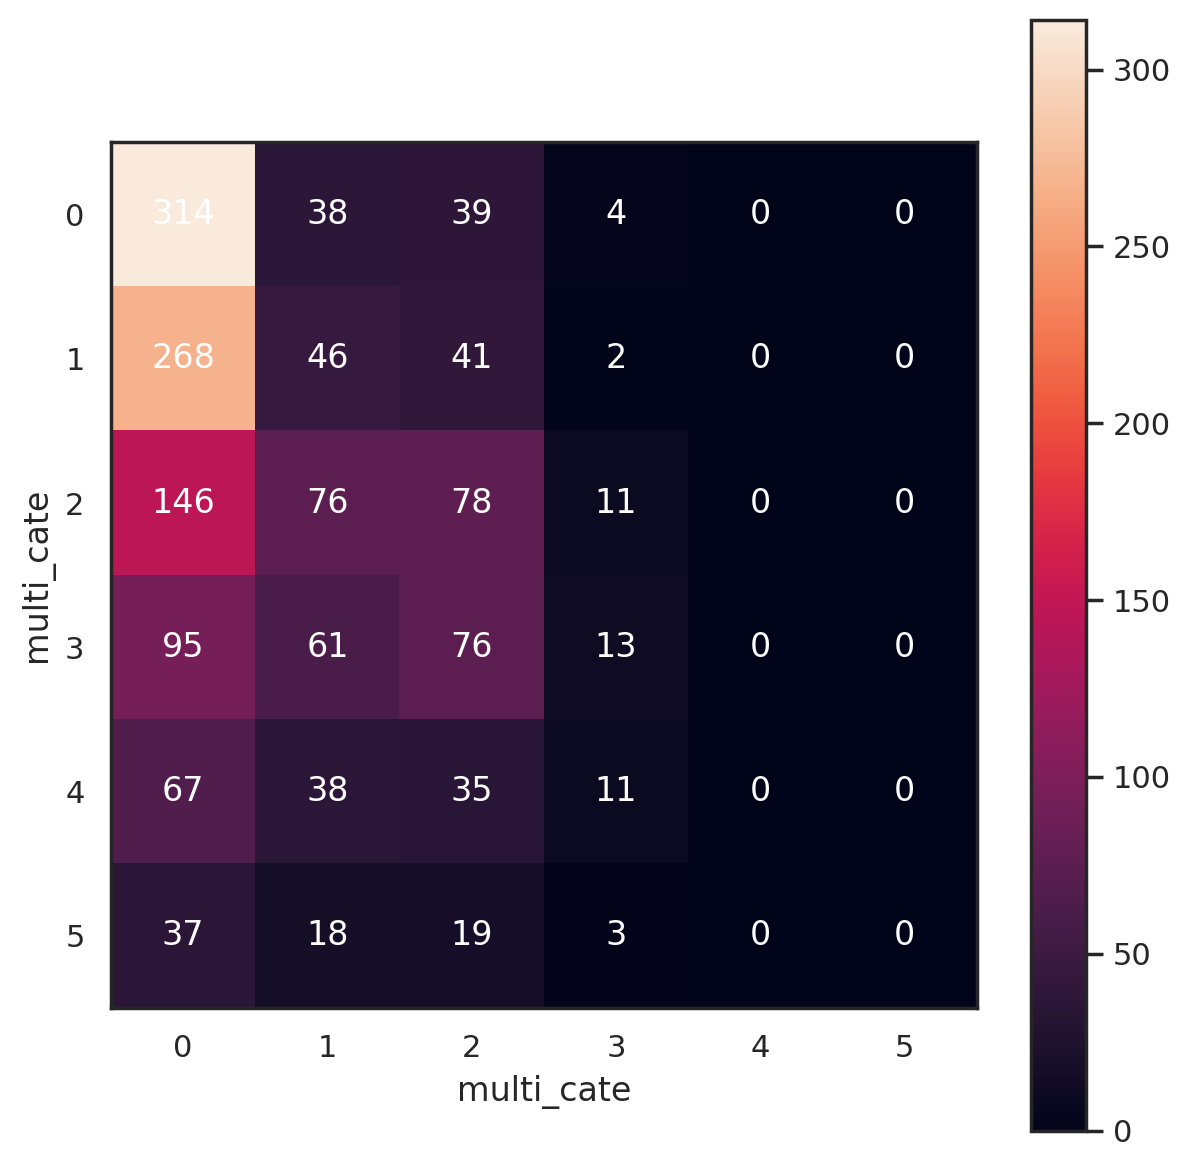

In [32]:
# Visualise Confusion Matrix
plt.figure(figsize=(6, 6), dpi=200)
sns.set(style='white')
X = range(1, 7)
Y = range(1, 7)

cm = np.array(total_matrix[0])
im = plt.imshow(cm)

for i in range(len(X)):
    for j in range(len(Y)):
        text = plt.text(j, i, cm[i, j], ha="center", va="center", color="w")
# plt.legend()
plt.colorbar(im)
plt.xticks(range(0,6))
plt.tight_layout()

plt.xlabel('multi_cate')
plt.ylabel('multi_cate')

plt.show()

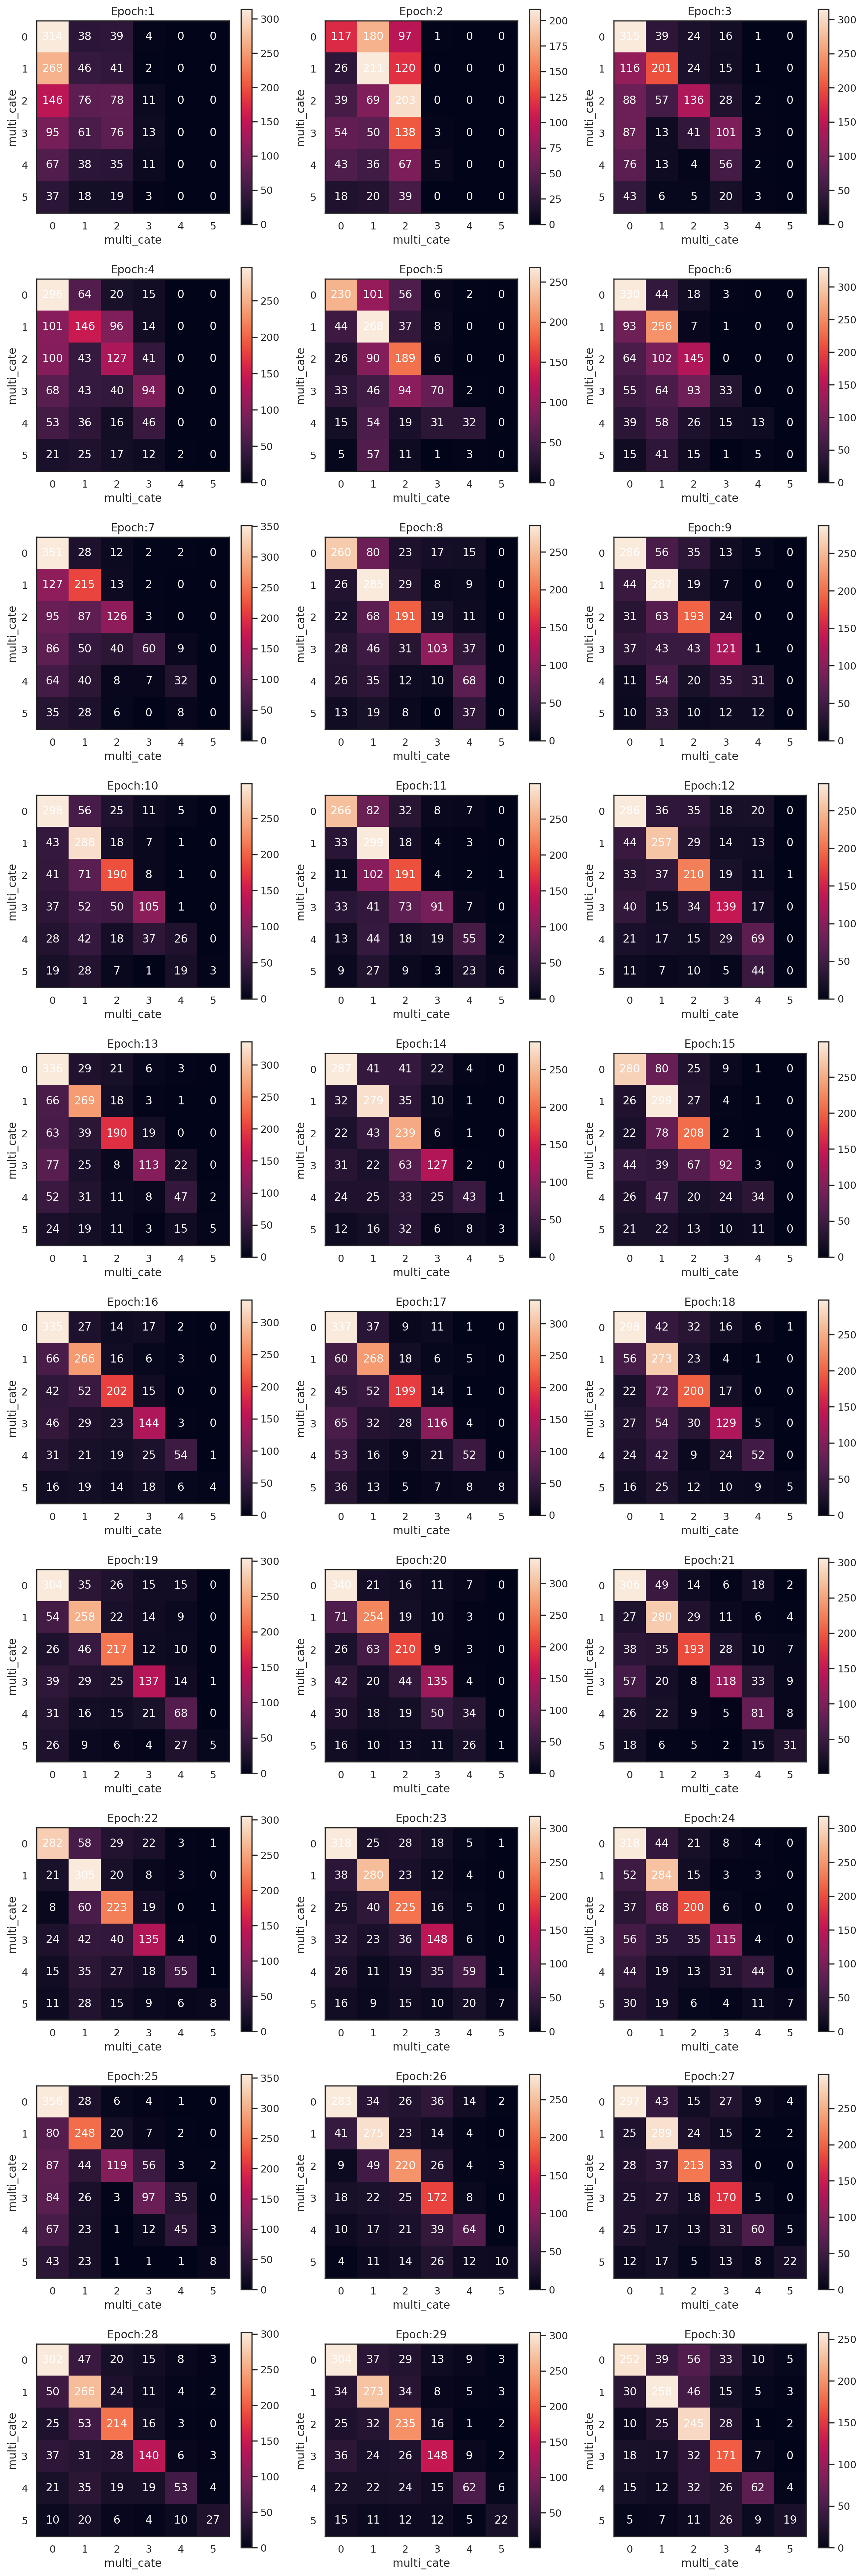

In [33]:
# Visualise Confusion Matrices by epoch

fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 50), dpi=200) 

epoch = 0
for ax in axs.flat:

    cm = np.array(total_matrix[epoch])
    im = ax.imshow(cm)

    for i in range(len(X)):
        for j in range(len(Y)):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="w")

    plt.colorbar(im)
    ax.set_title('Epoch:' +  str(epoch+1))

    ax.set_xlabel('multi_cate')
    ax.set_ylabel('multi_cate')
    epoch += 1
    
plt.savefig('test.png')